# Capstone Project
## TED Talk
#### Author: Diogo Viana

#### Contact: d.cviana@outlook.com
####                 https://www.linkedin.com/in/diogo-viana/

#### BrainStation - Data Science Diploma - 2022

# Table of Contents
1. [Introduction](#Introduction)
2. [The Bag-of-Words model](#The-Bag-of-Words-model)
    | 2.1[Logistic Regression, KNN & DT - Bag of Words](#Logistic-Regression,-KNN-&-DT---Bag-of-Words)
3. [Modeling](#Modeling)
    | 3.1[Logistic Regression](#Logistic-Regression)
    | 3.2[K-Nearest Neighbor Classifier](#K-Nearest-Neighbor-Classifier)
    | 3.3[Decision Tree Classifier](#Decision-Tree-Classifier)
4. [Models Summary](#Models-Summary)
5.[Decision Tree - Feature Importance](#Decision-Tree---Feature-Importance)
6.[Conclusion](#Conclusion)

### Introduction

Thank you for continuing with my analyses.

In this notebook, I am continuing the analysis of TED Talk, but now I completed the modeling part, and my target feature was views. Therefore, I started by applying Bag of Words in the description column.

After concatenating the results from the vectorization, I used Logistic Regression, KNN and Decision Trees models to determine which model had the better performance.

In addition, I also applied hyperparameter optimization and learned the improvements each model presented.

By the end of this notebook, I provided a description of TED talk, based on my best model, with the words highly correlated to a high number of views.

Moreover, I also supplied the information for the next notebook with RNN analysis.

In [119]:
# tools from the toolshed

import pandas as pd
pd.options.display.max_columns=None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.tree import DecisionTreeClassifier
from statsmodels.regression import linear_model

from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report


import json as json


import plotly.express as px

import statsmodels.api as sm


from scipy import stats
from scipy.stats import norm


import time

np.random.seed(12345)
import warnings
warnings.filterwarnings('ignore')

First, let us read in the data and profile what we are working with!

In [120]:
# Read in the csv
df = pd.read_csv('talks_info_clean.csv')

After I have read the data, I am able to start to work with it.

In [121]:
#Quickly check on the data

df.head(3)

,duration,ted_event,page_url,speaker_information,description,title,views,recorded_month,published_month,published_year,count_related_videos,count_subtitle_languages,count_topics,popularity_ratio
0,992,TED2006,https://www.ted.com/talks/mena_trott_meet_the_...,"[{""name"":""Mena Trott"",""occupation"":""Blogger; c...","The founding mother of the blog revolution, Mo...",Meet the founder of the blog revolution,589115,2,8,2006,6,21,8,2.885684
1,957,TED2006,https://www.ted.com/talks/al_gore_averting_the...,"[{""name"":""Al Gore"",""occupation"":""Climate advoc...",With the same humor and humanity he exuded in ...,Averting the climate crisis,3671801,2,6,2006,6,43,9,2.995805
2,1266,TED2006,https://www.ted.com/talks/david_pogue_simplici...,"[{""name"":""David Pogue"",""occupation"":""Technolog...",New York Times columnist David Pogue takes aim...,Simplicity sells,2008487,2,6,2006,6,27,8,2.987323


###  The Bag-of-Words model

For this part, in order to apply vectorization, I will transform the column `views` into binary.

First, I will check the minimum, mean and maximum and after that I will define where I will draw the line between `0` and `1`.

In [122]:
pd.DataFrame(df['views'].describe()).T

,count,mean,std,min,25%,50%,75%,max
views,5630.0,2.130771e+06,3.679699e+06,587.0,678755.25,1392235.5,2183246.25,73389142.0


In [123]:
df['views'].median()

1392235.5

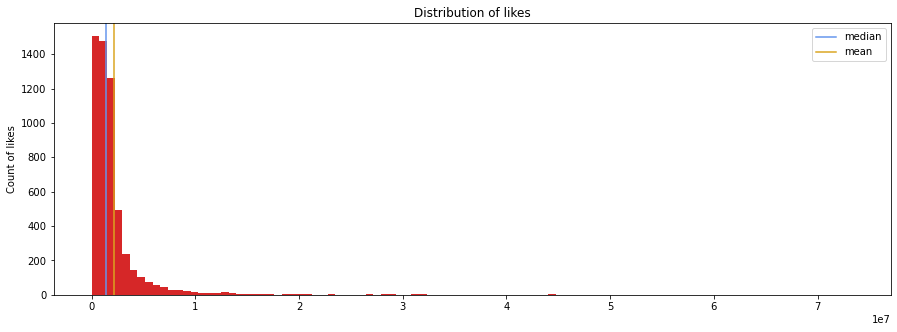

In [124]:
plt.figure(figsize=(15, 5))

plt.hist(df['views'], bins=100, color='tab:red')

# Overplot mean and median ages
plt.axvline(df['views'].median(), color='cornflowerblue', label='median')
plt.axvline(df['views'].mean(), color='goldenrod', label='mean')


plt.title('Distribution of likes')
plt.ylabel('Count of likes')
plt.legend()

plt.show()

As we can see, for the column `views`:

- minimum - 587 views
- mean - 2.371378e+06 views
- maximum - 73,389,142 views

- median - 1,392,235.5 views

According to the above investigation, I will make the division as following:

- Ted talks with less than 1,400,000 views will be transformed to `0`.


- Ted talks with equal or more than 1,400,000 views will be transformed to `1`.

In [125]:
# Creating the new binary column

df['sent_views'] = np.where(df['views'] >= 1400000, 1, 0)

In [126]:
# Checking if it worked and how balanced it is

df['sent_views'].value_counts()

0    2828
1    2802
Name: sent_views, dtype: int64

I will visualize the division to check for imbalance

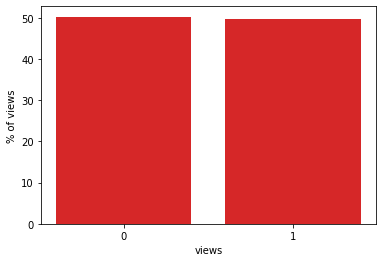

Class imbalance: [0.5 0.5]


In [127]:
# Plotting to better visualize

values, counts = np.unique(df['sent_views'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100, color='tab:red') # plot normalized counts
plt.xlabel('views')
plt.ylabel('% of views')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

As it could be seen, the division was well done and there is no imbalance after the creation of binary column.

As it could be seen, the division was well done and there is no imbalance after the creation of the binary column.

In [128]:
df.drop('views', axis=1, inplace=True)

Now that I converted the column `views` into binary and dropped the column `views`, I will define `X` and `y`.

In [129]:
# store simplified data in X and y

X = df['description']
y = df['sent_views']

In [130]:
# Checking y

y

0       0
1       1
2       1
3       1
4       0
       ..
5625    0
5626    0
5627    0
5628    0
5629    0
Name: sent_views, Length: 5630, dtype: int32

In [131]:
# Checking X

X

0       The founding mother of the blog revolution, Mo...
1       With the same humor and humanity he exuded in ...
2       New York Times columnist David Pogue takes aim...
3       Legendary scientist David Deutsch puts theoret...
4       Jehane Noujaim unveils her 2006 TED Prize wish...
                              ...                        
5625    In 2020, Mali produced over 71 tons of gold— a...
5626    Forget home economics and standardized tests, ...
5627    What if the commonly accepted narratives about...
5628    Your closet is likely full of all kinds of mat...
5629    Could DAOs, or "decentralized autonomous organ...
Name: description, Length: 5630, dtype: object

I will use:

* Train + Validation Sets: 80%
* Test Set: 20%

Let's separate our our test set and remainder:

In [132]:
# import the train test split
from sklearn.model_selection import train_test_split

# Taking a chuck for our 20% test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [133]:
# Checking after the first split

display(X_remainder.shape)
display(X_test.shape)

display(y_remainder.shape)
display(y_test.shape)

(4504,)

(1126,)

(4504,)

(1126,)

Now, `X_remainder` and `y_remainder` contain the other 80%. Of the remaining data, I will use 70% for the training set and 30% validation set.

In [134]:
# Splitting the remainder in two chunks

X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size = 0.3, stratify=y_remainder , random_state=42)

In [135]:
# Checking after the second split

display(X_train.shape)
display(X_validation.shape)

display(y_train.shape)
display(y_validation.shape)

(3152,)

(1352,)

(3152,)

(1352,)

###### Applying Bag-of-Words on the Reviews Data

Now I will make a document-term matrix that's based on our training data.

In [136]:
# 1. Instantiate
bagofwords = CountVectorizer()

# 2. Fit
bagofwords.fit(X_train)

# 3. Transform
X_train_transformed = bagofwords.transform(X_train)
X_train_transformed

<3152x19636 sparse matrix of type '<class 'numpy.int64'>'
	with 153483 stored elements in Compressed Sparse Row format>

In [137]:
X

0       The founding mother of the blog revolution, Mo...
1       With the same humor and humanity he exuded in ...
2       New York Times columnist David Pogue takes aim...
3       Legendary scientist David Deutsch puts theoret...
4       Jehane Noujaim unveils her 2006 TED Prize wish...
                              ...                        
5625    In 2020, Mali produced over 71 tons of gold— a...
5626    Forget home economics and standardized tests, ...
5627    What if the commonly accepted narratives about...
5628    Your closet is likely full of all kinds of mat...
5629    Could DAOs, or "decentralized autonomous organ...
Name: description, Length: 5630, dtype: object

In [138]:
bagofwords.transform(X_validation)

<1352x19636 sparse matrix of type '<class 'numpy.int64'>'
	with 61994 stored elements in Compressed Sparse Row format>

We can see that the sparse matrix (validation set) has 1,352 rows and 19,636 columns. This means that there are 19,636 unique terms or tokens. 

Now I will transform the tests set to both, train and validation, with the same features.

To see the above document-term matrix, I will extract the information out of the sparse matrix with the following functions: 

In [139]:
X_validation_transformed = bagofwords.transform(X_validation)
X_validation_transformed

<1352x19636 sparse matrix of type '<class 'numpy.int64'>'
	with 61994 stored elements in Compressed Sparse Row format>

Now I will take a look at some other features.

In [140]:
# taking some sample first

words = bagofwords.get_feature_names_out()
some_indices = range(1, 19636, round(19636/10)) # just pick some indices

samples = [words[i] for i in some_indices]
print(samples)

['05049', 'bike', 'cosas', 'equatorial', 'harvest', 'krznaric', 'narrowest', 'production', 'several', 'thrus']


I will extract the total counts for how many times they occur:

In [141]:
counts = np.array(X_train_transformed[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,05049,bike,cosas,equatorial,harvest,krznaric,narrowest,production,several,thrus
total_corpus_count,1,5,1,1,1,2,1,25,16,1


It is possible to see that summing up a column of our `X_train` document-term matrix gives how many times a token appeared in our overall corpus. 

Next I will show the most frequently occurring words next.

In [142]:
len(bagofwords.get_feature_names_out())

19636

In [143]:
X_train_transformed.toarray().sum(axis=0)

array([83,  1,  1, ...,  1,  1,  1], dtype=int64)

Now I will present the top 20 words and visualize the distribution of counts:

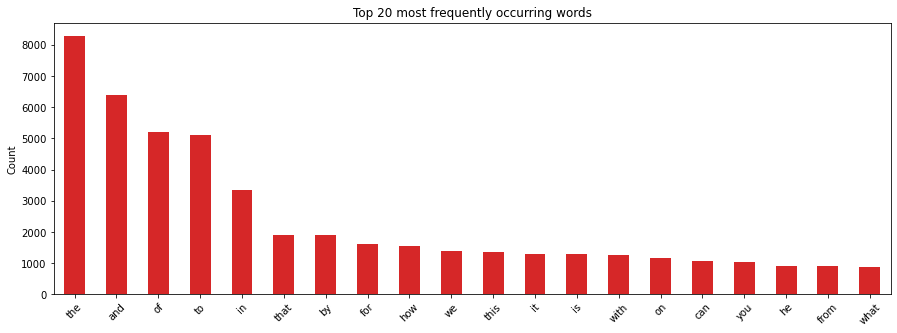

In [144]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), color='tab:red', legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Predictably the most common tokens are the known **stopwords**, which were `the`, `and`, `of` and so forth. These words are not very useful for our analyse. 

Therefore, next, I will use the same function `CountVectorizer()`, but this time I will add an argument for removing these `stop words`.

In [145]:
# Adding the **stop_words="english"** as argument in the function

bagofwords = CountVectorizer(stop_words="english")
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train) 
X_validation_transformed = bagofwords.transform(X_validation) 

X_train_transformed.shape

(3152, 19356)

As we can see, the number of features was reduced from `19,636` to `19,356`.

Now I will check the new most common words:

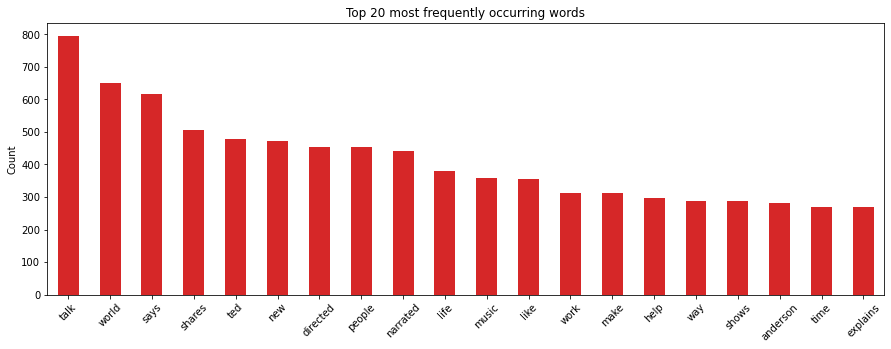

In [146]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), color='tab:red', legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Now, after removing `stop words` the most common words now are `talk`, `world` and `says`.

In [147]:
# Fitting a model
logreg = LogisticRegression(C = 0.1, max_iter=10000)
logreg.fit(X_train_transformed, y_train)

# Training and Validation score
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Validation score: {logreg.score(X_validation_transformed, y_validation)}")

Train score: 0.9581218274111675
Validation score: 0.5961538461538461


We can notice that the model is overfitting if use the validation set

I will use the logreg.coef to see which words have higher and lower power.

In [148]:
logreg.coef_

array([[ 0.23765189, -0.02575449,  0.0364379 , ...,  0.03276801,
         0.02578859, -0.03645763]])

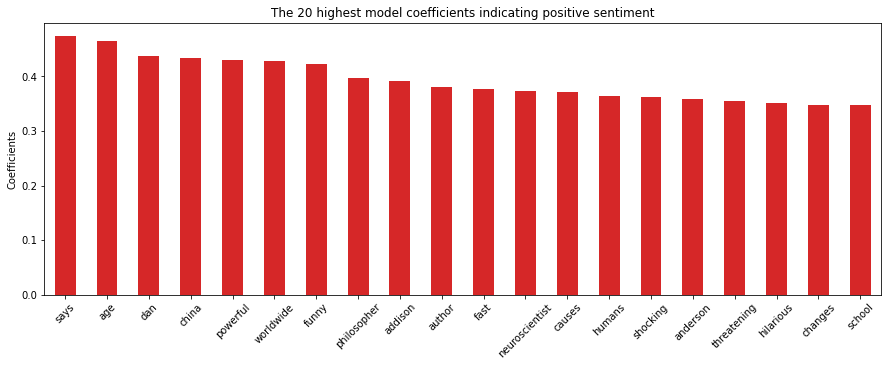

In [149]:
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bagofwords.get_feature_names()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), color='tab:red', legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

The words with most positive coefficient are `says` and `age`.

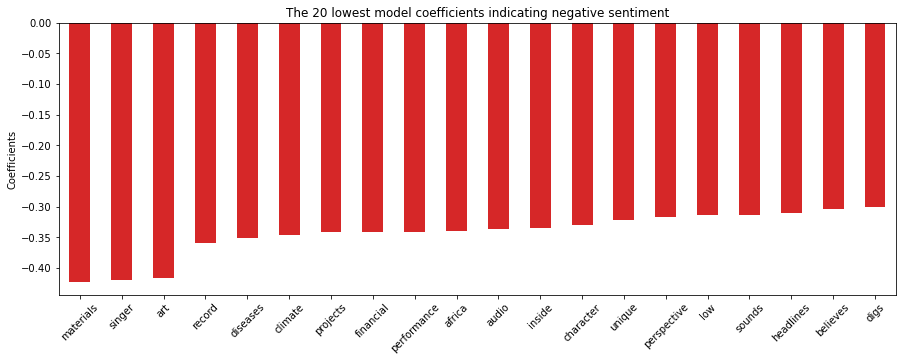

In [150]:
word_counts.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), color='tab:red', legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

And the words with yhe most negative coefficient are `materials` and `singer`.

Now I will verify the accuracy on the Test set.

Now I will transform the test set to both, train and test, with the same features.

To see the above document-term matrix, I will extract the information out of the sparse matrix with the following functions: 

In [151]:
X_test_transformed = bagofwords.transform(X_test)
X_test_transformed

<1126x19356 sparse matrix of type '<class 'numpy.int64'>'
	with 32381 stored elements in Compressed Sparse Row format>

As we can see the `X_test_transformed` has the same number of features of `X_train_transformed`.

In [152]:
X_test_transformed = bagofwords.transform(X_test)

In [153]:
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Validation score: {logreg.score(X_validation_transformed, y_validation)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.9581218274111675
Validation score: 0.5961538461538461
Test score: 0.6456483126110124


As we can see, the delta between the `train` and `test` sets are very high. We can say that this model is overfitting.

Now I will try to use a KNN with `n_neighbors=15` and Decision Tree with `max_depth=5` to compare the models perform:

In [154]:
# Instantiate - I will random choose a hyperparameter values...
knn = KNeighborsClassifier(n_neighbors=15)
dt = DecisionTreeClassifier(max_depth=5)

# Fit on the tranformed data
knn.fit(X_train_transformed, y_train)
dt.fit(X_train_transformed, y_train)

# Score
print(f'KNN train:{knn.score(X_train_transformed, y_train)}')
print(f'KNN test:{knn.score(X_test_transformed, y_test)}')
print(f'-------------------------')
print(f'Decision Tree train:{dt.score(X_train_transformed, y_train)}')
print(f'Decision Tree test:{dt.score(X_test_transformed, y_test)}')

KNN train:0.5041243654822335
KNN test:0.5026642984014209
-------------------------
Decision Tree train:0.5951776649746193
Decision Tree test:0.566607460035524


Both KNN and Decision Tree models got a very small accuracy on the test set. However, the delta between train and test are smaller than using Logistic Regression.

Now I will remove infrequent words by adding the min_df = 5 as argument in the function to exclude any token that occurs in less than 5 documents (one individual text file)

In [155]:
bagofwords = CountVectorizer(stop_words="english", min_df=5)
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)

X_train_transformed.shape

(3152, 3849)

We have dropped the number of words down to 3,849. That is a much bigger reduction. 

Now I will change the `max_features` parameter to limit the maximum number of features:

In [156]:
bagofwords = CountVectorizer(stop_words="english",
                             min_df=5,
                             max_features=1000)
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)

X_train_transformed.shape

(3152, 1000)

Now, I will use stemming to reduce the words to basic root form, which means for example remove `ing` and `s`.

For using stemer, I will use the Porter Stemmer from **nltk**.

In [157]:
import nltk

stemmer = nltk.stem.PorterStemmer()

In [158]:
bagofwords = CountVectorizer(min_df=5, 
                             tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')], 
                             stop_words='english')
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)
X_validation_transformed = bagofwords.transform(X_validation)
X_test_transformed = bagofwords.transform(X_test)

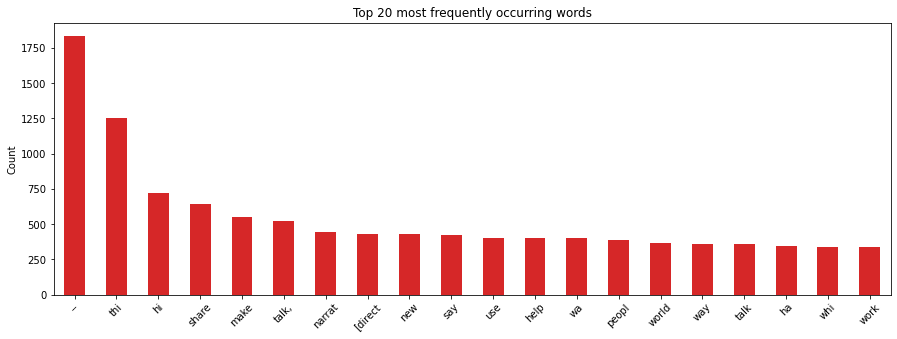

In [159]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), color='tab:red', legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

This time the graphic presented some weird results. Which could be punctuation or other things.

In order to fix this, I will define a function that should deal with punctuation before stemming.

In [160]:
# import the python string package

import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [161]:
# a dummy sentence used for checking this process
sentence = "The fast black cat, ran from the fat dog!!"

# after splitting the text based on spaces
split_sentence = sentence.split(' ')

# we stem and remove punctuation
tokenized_sentence = []
for word in split_sentence:
    for punctuation_mark in string.punctuation:
        word = word.replace(punctuation_mark, '')
    stemmed_word = stemmer.stem(word)
    tokenized_sentence.append(stemmed_word)
    
print(tokenized_sentence)

['the', 'fast', 'black', 'cat', 'ran', 'from', 'the', 'fat', 'dog']


In [162]:
# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [163]:
# checking tokenizer on simple sentence from above
my_tokenizer(sentence)

['fast', 'black', 'cat', 'ran', 'fat', 'dog']

In [164]:
bagofwords = CountVectorizer(min_df=5, 
                             tokenizer=my_tokenizer)
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)
X_validation_transformed = bagofwords.transform(X_validation)
X_test_transformed = bagofwords.transform(X_test)

X_train_transformed.shape

(3152, 3310)

Now we have 3,010 tokes.

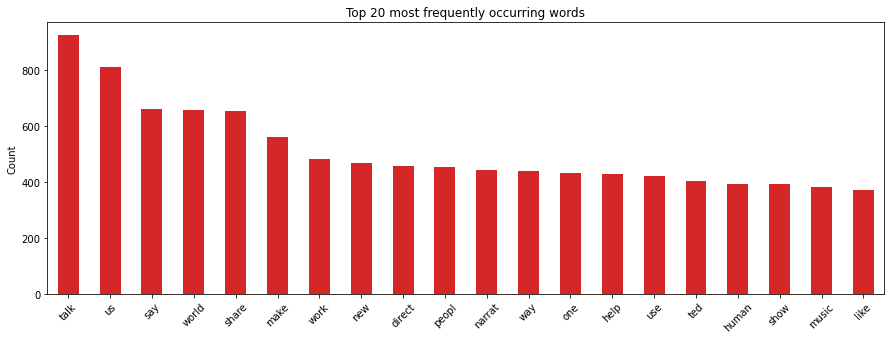

In [165]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), color='tab:red', legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The most common words might not make a lot of sense and some are cut off, but at least they are not stop words or punctuation. But in this case, the words make sense. 

#### Logistic Regression, KNN & DT - Bag of Words


Let's check how the models will respond to this modifications. 

In [166]:
# Fitting a model
logreg = LogisticRegression(C = 0.1, max_iter=10000)
logreg.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Validation score: {logreg.score(X_validation_transformed, y_validation)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.8597715736040609
Validation score: 0.606508875739645
Test score: 0.6314387211367674


In [167]:
# Instantiate - I will random choose a hyperparameter values...
knn = KNeighborsClassifier(n_neighbors=15)
dt = DecisionTreeClassifier(max_depth=5)

# Fit on the tranformed data
knn.fit(X_train_transformed, y_train)
dt.fit(X_train_transformed, y_train)

# Score
print(f'KNN train:{knn.score(X_train_transformed, y_train)}')
print(f'KNN test:{knn.score(X_test_transformed, y_test)}')
print(f'-------------------------')
print(f'Decision Tree train:{dt.score(X_train_transformed, y_train)}')
print(f'Decision Tree test:{dt.score(X_test_transformed, y_test)}')

KNN train:0.5041243654822335
KNN test:0.5035523978685613
-------------------------
Decision Tree train:0.5866116751269036
Decision Tree test:0.566607460035524


After cleaning the tokes, we have a model with less features than before and the accuracy using Logistic Regression on the test set slightly decreased (~1.42%).

While with KNN and DT the variance was even smaller.

In [168]:
X_train_pd = pd.DataFrame(X_train_transformed.toarray(),columns=bagofwords.get_feature_names())
X_validation_pd = pd.DataFrame(X_validation_transformed.toarray(),columns=bagofwords.get_feature_names())
X_test_pd = pd.DataFrame(X_test_transformed.toarray(),columns=bagofwords.get_feature_names())

Now I will concatenate the vectorized `X_train` and `X_test` wih `df`. To not change original `df`, I will create a new `df` with the new features.

In [169]:
X_train_pd.shape

(3152, 3310)

In [170]:
X_validation_pd.shape

(1352, 3310)

In [171]:
X_test_pd.shape

(1126, 3310)

In [172]:
df.shape

(5630, 14)

In [173]:
df_vec = pd.concat([X_train_pd, X_validation_pd, X_test_pd], axis=0)

In [174]:
# Checking if the pd.concat worked

df_vec.isnull().sum()

1            0
10           0
100          0
1000         0
10000        0
            ..
zimmerman    0
zone         0
–            0
—            0
…            0
Length: 3310, dtype: int64

In [175]:
df_vec.shape

(5630, 3310)

In [176]:
df.shape

(5630, 14)

In [177]:
# Using pd.concat with reset index to concatenate df with df_vec (X_train and X_test)

df_vec = pd.concat([df.reset_index(), df_vec.reset_index()], axis=1)

In [178]:
# Checking new df_vec

df_vec.head(2)

,index,duration,ted_event,page_url,speaker_information,description,title,recorded_month,published_month,published_year,count_related_videos,count_subtitle_languages,count_topics,popularity_ratio,sent_views,index,1,10,100,1000,10000,11,12,13,14,15,150,16,17,18,19,1950,1980,2,20,200,2000,2003,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2020,2021,2050,20th,21st,22,24,25,3,30,300,3000,3d,4,40,5,50,500,6,60,7,70,8,80,9,90,aaron,abandon,abil,abl,aboard,absolut,abstract,abund,abus,academ,acceler,accept,access,accid,accident,acclaim,accompani,accomplish,accord,account,accur,achiev,acknowledg,across,act,action,activ,activist,actor,actress,actual,ad,adam,adapt,add,addict,addison,addit,address,admit,adopt,adrian,adult,advanc,advantag,adventur,advertis,advic,advis,advoc,advocaci,aerial,affair,affect,afford,afghanistan,afraid,africa,african,age,agenc,ago,agre,agreement,agricultur,ahead,ai,aid,aim,air,airplan,al,alan,alarm,album,alex,alexand,alexandra,algorithm,ali,alic,alien,alik,aliv,allan,allen,alli,allianc,allow,almost,alon,along,alongsid,alreadi,also,alter,altern,alway,alzheim,amanda,amaz,amazon,amber,ambit,ambiti,america,american,ami,among,amount,amplifi,analysi,analyst,analyt,analyz,anatomi,ancestor,ancient,anderson,andrea,andrew,andré,anecdot,angel,angela,anger,anim,ann,anna,announc,annual,anonym,anoth,answer,antarctica,anthoni,anthropologist,antibiot,anticip,anton,antonio,anxieti,anyon,anyth,anyway,anywher,aparna,apart,apollo,app,appeal,appear,appl,appli,applic,appreci,approach,april,arab,archaeolog,archaeologist,architect,architectur,archiv,area,arent,argu,argument,ari,arm,armi,armstrong,around,arrang,array,arrest,arriv,art,arthur,articl,artifact,artifici,artist,artrak,ash,asid,ask,aspect,aspir,assess,assign,assist,associ,assum,assumpt,asteroid,astonish,astronaut,astronom,astrophysicist,athlet,atiba,atmospher,atom,attach,attack,attempt,attent,attitud,attorney,attract,audaci,audienc,audio,audiocollectivetedcom,augment,authent,author,autism,autom,autonom,avail,averag,avert,avi,avoid,aw,await,awar,award,away,awesom,b,babi,back,background,backward,bacteria,bad,bag,baker,balanc,ball,ballot,bamm,ban,band,bang,bank,bar,bare,barrier,base,basi,basic,bat,bathroom,battl,bce,be,beach,beam,bear,beat,beatbox,beauti,becam,becom,bed,began,begin,behalf,behav,behavior,behind,belief,believ,bell,belong,belov,ben,beneath,benefit,benjamin,berri,best,bethani,better,beyond,bhayani,bia,bias,biello,big,bigger,biggest,bike,biljana,bill,billion,biodivers,biolog,biologist,biotech,bird,birth,bit,bizarr,black,blend,blind,block,blockchain,blood,blue,blueprint,blur,bob,bodi,bogati,bold,boldli,bomb,bond,bone,book,boom,boost,borda,border,bore,born,borrow,boston,bottl,bottom,boundari,box,boy,brain,brand,brave,brazil,brazilian,break,breakthrough,breath,breathtak,breed,brett,brian,bridg,brief,bright,brilliant,bring,british,broken,brook,brother,brought,brown,bruce,bruno,brush,brutal,bryce,budget,bug,build,builder,built,bullet,bulli,buri,burn,burst,busi,buy,c,cabong,cage,calcul,california,call,came,camera,cameron,camil,camp,campaign,cancer,candi,candid,cannot,cant,capabl,capac,capit,capitalist,captiv,captur,car,carbon,care,career,carl,carlo,carolin,carri,case,cash,cast,cat,catastroph,catch,catherin,caught,caus,cave,celebr,cell,cellist,cello,cem,cement,center,central,centuri,centuriesold,ceo,cern,certain,cg,chain,chair,chalabi,challeng,champion,chanc,chang,channel,chao,chaotic,charact,characterist,charg,charl,charla,charlott,charm,chart,chase,cheap,cheaper,check,chee,chef,chemic,chemist,chemistri,chen,chicken,chief,child,childhood,children,china,chines,chip,choic,cholera,choos,choreograph,chri,christian,christina,christoph,chronic,circl,circular,circumst,cite,citi,citizen,civic,civil,civilian,claim,clariti,class,classic,classroom,claudia,clay,clean,cleaner,clear,clearli,clever,climat,climb,clinic,clip,cloe,close,closer,closest,cloth,cloud,club,clue,coach,coalit,coast,coastal,code,coder,coffe,cofound,cognit,coin,cold,coleman,collabor,collaps,colleagu,

As we could see, there are 2 columns named `Index`. So, I drop it to not impact in the analyse.

In [179]:
df_vec.drop('index', axis=1, inplace=True)

In [180]:
# Checking new df_vec

df_vec.head(2)

,duration,ted_event,page_url,speaker_information,description,title,recorded_month,published_month,published_year,count_related_videos,count_subtitle_languages,count_topics,popularity_ratio,sent_views,1,10,100,1000,10000,11,12,13,14,15,150,16,17,18,19,1950,1980,2,20,200,2000,2003,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2020,2021,2050,20th,21st,22,24,25,3,30,300,3000,3d,4,40,5,50,500,6,60,7,70,8,80,9,90,aaron,abandon,abil,abl,aboard,absolut,abstract,abund,abus,academ,acceler,accept,access,accid,accident,acclaim,accompani,accomplish,accord,account,accur,achiev,acknowledg,across,act,action,activ,activist,actor,actress,actual,ad,adam,adapt,add,addict,addison,addit,address,admit,adopt,adrian,adult,advanc,advantag,adventur,advertis,advic,advis,advoc,advocaci,aerial,affair,affect,afford,afghanistan,afraid,africa,african,age,agenc,ago,agre,agreement,agricultur,ahead,ai,aid,aim,air,airplan,al,alan,alarm,album,alex,alexand,alexandra,algorithm,ali,alic,alien,alik,aliv,allan,allen,alli,allianc,allow,almost,alon,along,alongsid,alreadi,also,alter,altern,alway,alzheim,amanda,amaz,amazon,amber,ambit,ambiti,america,american,ami,among,amount,amplifi,analysi,analyst,analyt,analyz,anatomi,ancestor,ancient,anderson,andrea,andrew,andré,anecdot,angel,angela,anger,anim,ann,anna,announc,annual,anonym,anoth,answer,antarctica,anthoni,anthropologist,antibiot,anticip,anton,antonio,anxieti,anyon,anyth,anyway,anywher,aparna,apart,apollo,app,appeal,appear,appl,appli,applic,appreci,approach,april,arab,archaeolog,archaeologist,architect,architectur,archiv,area,arent,argu,argument,ari,arm,armi,armstrong,around,arrang,array,arrest,arriv,art,arthur,articl,artifact,artifici,artist,artrak,ash,asid,ask,aspect,aspir,assess,assign,assist,associ,assum,assumpt,asteroid,astonish,astronaut,astronom,astrophysicist,athlet,atiba,atmospher,atom,attach,attack,attempt,attent,attitud,attorney,attract,audaci,audienc,audio,audiocollectivetedcom,augment,authent,author,autism,autom,autonom,avail,averag,avert,avi,avoid,aw,await,awar,award,away,awesom,b,babi,back,background,backward,bacteria,bad,bag,baker,balanc,ball,ballot,bamm,ban,band,bang,bank,bar,bare,barrier,base,basi,basic,bat,bathroom,battl,bce,be,beach,beam,bear,beat,beatbox,beauti,becam,becom,bed,began,begin,behalf,behav,behavior,behind,belief,believ,bell,belong,belov,ben,beneath,benefit,benjamin,berri,best,bethani,better,beyond,bhayani,bia,bias,biello,big,bigger,biggest,bike,biljana,bill,billion,biodivers,biolog,biologist,biotech,bird,birth,bit,bizarr,black,blend,blind,block,blockchain,blood,blue,blueprint,blur,bob,bodi,bogati,bold,boldli,bomb,bond,bone,book,boom,boost,borda,border,bore,born,borrow,boston,bottl,bottom,boundari,box,boy,brain,brand,brave,brazil,brazilian,break,breakthrough,breath,breathtak,breed,brett,brian,bridg,brief,bright,brilliant,bring,british,broken,brook,brother,brought,brown,bruce,bruno,brush,brutal,bryce,budget,bug,build,builder,built,bullet,bulli,buri,burn,burst,busi,buy,c,cabong,cage,calcul,california,call,came,camera,cameron,camil,camp,campaign,cancer,candi,candid,cannot,cant,capabl,capac,capit,capitalist,captiv,captur,car,carbon,care,career,carl,carlo,carolin,carri,case,cash,cast,cat,catastroph,catch,catherin,caught,caus,cave,celebr,cell,cellist,cello,cem,cement,center,central,centuri,centuriesold,ceo,cern,certain,cg,chain,chair,chalabi,challeng,champion,chanc,chang,channel,chao,chaotic,charact,characterist,charg,charl,charla,charlott,charm,chart,chase,cheap,cheaper,check,chee,chef,chemic,chemist,chemistri,chen,chicken,chief,child,childhood,children,china,chines,chip,choic,cholera,choos,choreograph,chri,christian,christina,christoph,chronic,circl,circular,circumst,cite,citi,citizen,civic,civil,civilian,claim,clariti,class,classic,classroom,claudia,clay,clean,cleaner,clear,clearli,clever,climat,climb,clinic,clip,cloe,close,closer,closest,cloth,cloud,club,clue,coach,coalit,coast,coastal,code,coder,coffe,cofound,cognit,coin,cold,coleman,collabor,collaps,colleagu,collect,coll

In [181]:
# Checking if the pd.concat worked

df_vec.isnull().sum()

duration               0
ted_event              0
page_url               0
speaker_information    0
description            0
                      ..
zimmerman              0
zone                   0
–                      0
—                      0
…                      0
Length: 3324, dtype: int64

### Modeling

### Logistic Regression | K-Nearest Neighbors | Decision Trees

Now I will use this new dataset to perform a deeper analyse

Next, I will split it into `Train`, `Validation` and `Test` sets again. But first I will need to remove the non_numerical columns for this part.

**The target column will be `views`.**

In this part I would like to understand how we could predict if the TED talk will receive more views based on the other features.

In [182]:
df_vec.dtypes

duration                int64
ted_event              object
page_url               object
speaker_information    object
description            object
                        ...  
zimmerman               int64
zone                    int64
–                       int64
—                       int64
…                       int64
Length: 3324, dtype: object

Next, I will drop all the non numerical columns.

In [183]:
df_vec.drop('ted_event', axis=1, inplace=True)
df_vec.drop('page_url', axis=1, inplace=True)
df_vec.drop('speaker_information', axis=1, inplace=True)
df_vec.drop('description', axis=1, inplace=True)
df_vec.drop('title', axis=1, inplace=True)

In [184]:
# No mor non_numerical column

df_vec.dtypes

duration                int64
recorded_month          int64
published_month         int64
published_year          int64
count_related_videos    int64
                        ...  
zimmerman               int64
zone                    int64
–                       int64
—                       int64
…                       int64
Length: 3319, dtype: object

In [185]:
# Checking new df_vec

df_vec.head(2)

,duration,recorded_month,published_month,published_year,count_related_videos,count_subtitle_languages,count_topics,popularity_ratio,sent_views,1,10,100,1000,10000,11,12,13,14,15,150,16,17,18,19,1950,1980,2,20,200,2000,2003,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2020,2021,2050,20th,21st,22,24,25,3,30,300,3000,3d,4,40,5,50,500,6,60,7,70,8,80,9,90,aaron,abandon,abil,abl,aboard,absolut,abstract,abund,abus,academ,acceler,accept,access,accid,accident,acclaim,accompani,accomplish,accord,account,accur,achiev,acknowledg,across,act,action,activ,activist,actor,actress,actual,ad,adam,adapt,add,addict,addison,addit,address,admit,adopt,adrian,adult,advanc,advantag,adventur,advertis,advic,advis,advoc,advocaci,aerial,affair,affect,afford,afghanistan,afraid,africa,african,age,agenc,ago,agre,agreement,agricultur,ahead,ai,aid,aim,air,airplan,al,alan,alarm,album,alex,alexand,alexandra,algorithm,ali,alic,alien,alik,aliv,allan,allen,alli,allianc,allow,almost,alon,along,alongsid,alreadi,also,alter,altern,alway,alzheim,amanda,amaz,amazon,amber,ambit,ambiti,america,american,ami,among,amount,amplifi,analysi,analyst,analyt,analyz,anatomi,ancestor,ancient,anderson,andrea,andrew,andré,anecdot,angel,angela,anger,anim,ann,anna,announc,annual,anonym,anoth,answer,antarctica,anthoni,anthropologist,antibiot,anticip,anton,antonio,anxieti,anyon,anyth,anyway,anywher,aparna,apart,apollo,app,appeal,appear,appl,appli,applic,appreci,approach,april,arab,archaeolog,archaeologist,architect,architectur,archiv,area,arent,argu,argument,ari,arm,armi,armstrong,around,arrang,array,arrest,arriv,art,arthur,articl,artifact,artifici,artist,artrak,ash,asid,ask,aspect,aspir,assess,assign,assist,associ,assum,assumpt,asteroid,astonish,astronaut,astronom,astrophysicist,athlet,atiba,atmospher,atom,attach,attack,attempt,attent,attitud,attorney,attract,audaci,audienc,audio,audiocollectivetedcom,augment,authent,author,autism,autom,autonom,avail,averag,avert,avi,avoid,aw,await,awar,award,away,awesom,b,babi,back,background,backward,bacteria,bad,bag,baker,balanc,ball,ballot,bamm,ban,band,bang,bank,bar,bare,barrier,base,basi,basic,bat,bathroom,battl,bce,be,beach,beam,bear,beat,beatbox,beauti,becam,becom,bed,began,begin,behalf,behav,behavior,behind,belief,believ,bell,belong,belov,ben,beneath,benefit,benjamin,berri,best,bethani,better,beyond,bhayani,bia,bias,biello,big,bigger,biggest,bike,biljana,bill,billion,biodivers,biolog,biologist,biotech,bird,birth,bit,bizarr,black,blend,blind,block,blockchain,blood,blue,blueprint,blur,bob,bodi,bogati,bold,boldli,bomb,bond,bone,book,boom,boost,borda,border,bore,born,borrow,boston,bottl,bottom,boundari,box,boy,brain,brand,brave,brazil,brazilian,break,breakthrough,breath,breathtak,breed,brett,brian,bridg,brief,bright,brilliant,bring,british,broken,brook,brother,brought,brown,bruce,bruno,brush,brutal,bryce,budget,bug,build,builder,built,bullet,bulli,buri,burn,burst,busi,buy,c,cabong,cage,calcul,california,call,came,camera,cameron,camil,camp,campaign,cancer,candi,candid,cannot,cant,capabl,capac,capit,capitalist,captiv,captur,car,carbon,care,career,carl,carlo,carolin,carri,case,cash,cast,cat,catastroph,catch,catherin,caught,caus,cave,celebr,cell,cellist,cello,cem,cement,center,central,centuri,centuriesold,ceo,cern,certain,cg,chain,chair,chalabi,challeng,champion,chanc,chang,channel,chao,chaotic,charact,characterist,charg,charl,charla,charlott,charm,chart,chase,cheap,cheaper,check,chee,chef,chemic,chemist,chemistri,chen,chicken,chief,child,childhood,children,china,chines,chip,choic,cholera,choos,choreograph,chri,christian,christina,christoph,chronic,circl,circular,circumst,cite,citi,citizen,civic,civil,civilian,claim,clariti,class,classic,classroom,claudia,clay,clean,cleaner,clear,clearli,clever,climat,climb,clinic,clip,cloe,close,closer,closest,cloth,cloud,club,clue,coach,coalit,coast,coastal,code,coder,coffe,cofound,cognit,coin,cold,coleman,collabor,collaps,colleagu,collect,collector,colleg,collid,colm,colman,coloni,color,columnist,co

Now, I will split with the X and y.

In [186]:
# Defining X and y

X_baseline = df_vec.drop('sent_views', axis=1)

y_baseline = df_vec['sent_views']

In [187]:
X_baseline.head()

duration  recorded_month  published_month  published_year  \
0       992               2                8            2006   
1       957               2                6            2006   
2      1266               2                6            2006   
3      1126               7                9            2006   
4      1524               2                7            2006   

   count_related_videos  count_subtitle_languages  count_topics  \
0                     6                        21             8   
1                     6                        43             9   
2                     6                        27             8   
3                     6                        29             8   
4                     6                        20             8   

   popularity_ratio  1  10  100  1000  10000  11  12  13  14  15  150  16  17  \
0          2.885684  0   0    0     0      0   0   0   0   0   0    0   0   0   
1          2.995805  0   0    0     0      0   0   0   0   0   0    0   0   0   
2          2.987323  0   0    0     0      0   0   0   0   0   0    0   0   0   
3          2.969279  0   0    0     0      0   0   0   0   0   0    0   0   0   
4          2.858560  0   0    0     0      0   0   0   0   0   0    0   0   0   

   18  19  1950  1980  2  20  200  2000  2003  2006  2007  2008  2009  2010  \
0   0   0     1     0  0   0    0     0     0     0     0     0     0     0   
1   0   0     0     0  0   0    0     0     0     0     0     0     0     0   
2   0   0     0     0  0   0    0     0     0     0     0     0     0     0   
3   0   0     0     0  0   0    0     0     0     0     0     0     0     0   
4   0   0     0     0  0   0    0     0     0     0     0     0     0     0   

   2011  2012  2013  2014  2015  2016  2017  2018  2020  2021  2050  20th  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   21st  22  24  25  3  30  300  3000  3d  4  40  5  50  500  6  60  7  70  8  \
0     0   0   0   0  0   0    0     0   0  0   0  0   0    0  0   0  0   0  0   
1     0   0   0   0  0   0    0     0   0  0   0  0   0    0  0   0  0   0  0   
2     0   0   0   0  0   0    0     0   0  0   0  0   0    0  0   0  0   0  0   
3     0   0   0   0  0   0    0     0   0  0   0  0   0    0  0   0  0   0  0   
4     0   0   0   0  0   0    0     0   0  0   0  0   0    0  0   0  0   0  0   

   80  9  90  aaron  abandon  abil  abl  aboard  absolut  abstract  abund  \
0   0  0   0      0        0     0    1       0        0         0      0   
1   0  0   0      0        0     0    0       0        0         0      0   
2   0  0   0      0        0     0    0       0        0         0      0   
3   0  0   0      0        0     0    0       0        0         0      0   
4   0  0   0      0        0     0    0       0        0         0      0   

   abus  academ  acceler  accept  access  accid  accident  acclaim  accompani  \
0     0       0        0       0       0      0         0        0          0   
1     0       0        0       0       0      0         0        0          0   
2     0       0        0       0       0      0         0        0          0   
3     0       0        0       0       0      0         0        0          0   
4     0       0        0       0       0      0         0        0          0   

   accomplish  accord  account  accur  achiev  acknowledg  across  act  \
0           0       0        0      0       0           0       0    0   
1           0       0        0      0       0           0       0    0   
2           0       0        0      0       0           0       0    0   
3           0       0        0      0       0           0

In [188]:
y_baseline.head()

0    0
1    1
2    1
3    1
4    0
Name: sent_views, dtype: int32

I will use:

* Train + Validation Sets: 80%
* Test Set: 20%

Let's separate our test set.

In [189]:
# Splitting out 20% for test set
X_baseline_remainder, X_baseline_test, y_baseline_remainder, y_baseline_test = \
    train_test_split(X_baseline, y_baseline, test_size = 0.2,random_state=42,stratify=y_baseline)

In [190]:
# Checking after the first split

display(X_baseline_remainder.shape)
display(X_baseline_test.shape)

display(y_baseline_remainder.shape)
display(y_baseline_test.shape)

(4504, 3318)

(1126, 3318)

(4504,)

(1126,)

In [191]:
# Splitting the remainder in two chunks

X_baseline_train, X_baseline_validation, y_baseline_train, y_baseline_validation = \
    train_test_split(X_baseline_remainder, y_baseline_remainder, test_size = 0.2,\
                     random_state=42,stratify=y_baseline_remainder)

In [192]:
# Checking after the first split

display(X_baseline_train.shape)
display(X_baseline_validation.shape)
display(X_baseline_test.shape)

display(y_baseline_train.shape)
display(y_baseline_validation.shape)
display(y_baseline_test.shape)

(3603, 3318)

(901, 3318)

(1126, 3318)

(3603,)

(901,)

(1126,)

Now I will scale the data set.

Since most parts of the data set are between 0  and 1, I will apply MinMaxScaler to not change the distribution.

In [193]:
# Import MInMax Scaler

from sklearn.preprocessing import MinMaxScaler

In [194]:
### SCALING

# Instantiate scaler
scaler = MinMaxScaler()

# Fit and transform the TRAINING DATA
X_baseline_train_scaled = scaler.fit_transform(X_baseline_train)

# Transform - all the datasets
X_baseline_validation_scaled = scaler.transform(X_baseline_validation)
X_baseline_test_scaled = scaler.transform(X_baseline_test)

### Logistic Regression

I will start by using the Logistic Regression and see how it performs.

First, I will use the plain model.

In [195]:
# Instantiate the model
my_logreg_basic = LogisticRegression(random_state=42,max_iter=2000).fit(X_baseline_train_scaled, y_baseline_train)

#score model against data subsets
my_logreg_basic_train_acc = my_logreg_basic.score(X_baseline_train_scaled, y_baseline_train)

my_logreg_basic_val_acc = my_logreg_basic.score(X_baseline_validation_scaled, y_baseline_validation)

my_logreg_basic_test_acc = my_logreg_basic.score(X_baseline_test_scaled, y_baseline_test)

print(f"Train accuracy: {(round(my_logreg_basic_train_acc,4)*100)}")
print(f"Validation accuracy: {(round(my_logreg_basic_val_acc,4)*100)}")
print(f"Test accuracy: {(round(my_logreg_basic_test_acc,4)*100)}")

Train accuracy: 95.61
Validation accuracy: 68.47999999999999
Test accuracy: 71.23


Now, I will run different values for `C` and then plot the results to understand which is the best `C` for our model.

In [196]:
# values of C to interate over
C_values = (.00001,.0001,.001,.01,.1,1,10,100,1000)

# create an empty list to store accuracy scores
train_acc = []
val_acc = []

# loop model interactions across all C-values

for C in C_values:
    logit_C = LogisticRegression(random_state=42, max_iter=2000, C=C).fit(X_baseline_train_scaled, y_baseline_train)
    train_acc.append(logit_C.score(X_baseline_train_scaled, y_baseline_train))
    val_acc.append(logit_C.score(X_baseline_validation_scaled, y_baseline_validation))
    print(f"C {C} completed")

C 1e-05 completed
C 0.0001 completed
C 0.001 completed
C 0.01 completed
C 0.1 completed
C 1 completed
C 10 completed
C 100 completed
C 1000 completed


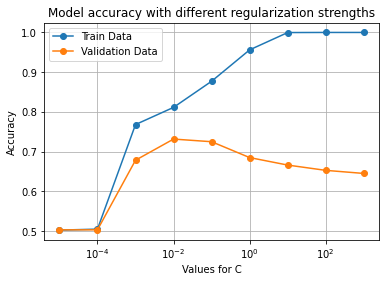

In [197]:
# Visualization part - accuracy scores across C-values

plt.figure()
plt.plot(C_values, train_acc, marker='o',label='Train Data')
plt.plot(C_values, val_acc, marker='o',label='Validation Data')
plt.xscale("log")

plt.xlabel('Values for C')
plt.ylabel('Accuracy')

plt.legend()
plt.title('Model accuracy with different regularization strengths')
plt.grid()
plt.show();

Based on this plot, the optimum `C` value should be 10^-2(0.01). I believe this is the best `C` because it has the smaller gap between Validation and Train. As we could see above, after 10^-2 the validation started to drop and train to rise.

In [198]:
# Instantiate the model
my_logreg01 = LogisticRegression(C=0.01,random_state=42,max_iter=2000).fit(X_baseline_train_scaled, y_baseline_train)

#score model against data subsets
my_logreg01_train_acc = my_logreg01.score(X_baseline_train_scaled, y_baseline_train)

my_logreg01_val_acc = my_logreg01.score(X_baseline_validation_scaled, y_baseline_validation)

my_logreg01_test_acc = my_logreg01.score(X_baseline_test_scaled, y_baseline_test)

print(f"Train accuracy: {(round(my_logreg01_train_acc,4)*100)}")
print(f"Validation accuracy: {(round(my_logreg01_val_acc,4)*100)}")
print(f"Test accuracy: {(round(my_logreg01_test_acc,4)*100)}")

Train accuracy: 81.13
Validation accuracy: 73.14
Test accuracy: 72.11


Even after applying some Hyperparameters optimization, the accuracy on the Test set is still low. As we can observe above, the accuracy for the Test set is much lower than the Train set.

I will perform 5-fold cross-validation to see if the performance of the model improves. But I will use the original data.

For the next part, I will use `pipeline` and optimize multiple hyperparameters (`C` and `solver`) in one code block.

Even if I already checked the optimum `C` value, I will double check it in the next line.

In [199]:
# Instantiating the model
estimators = [('scaler', MinMaxScaler()),
             ('model', LogisticRegression())]
             

# Instantiating pipeline
pipe = Pipeline(estimators)

# Defining the models
params = [
            {'model': [LogisticRegression(random_state=42,max_iter=2000)],
            'scaler': [MinMaxScaler()],
            'model__C': [0.001,0.01,0.1,1,10],
            'model__solver': ['lbfgs', 'liblinear']}           
]

#cosolidating all interactions into one loop / verbose = 2 to shor the progress
qgrid_search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)

# fitting the model specifications
fitted_search = qgrid_search.fit(X_baseline, y_baseline)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model=LogisticRegression(max_iter=2000, random_state=42), model__C=0.001, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   1.8s
[CV] END model=LogisticRegression(max_iter=2000, random_state=42), model__C=0.001, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   1.7s
[CV] END model=LogisticRegression(max_iter=2000, random_state=42), model__C=0.001, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   1.9s
[CV] END model=LogisticRegression(max_iter=2000, random_state=42), model__C=0.001, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   1.8s
[CV] END model=LogisticRegression(max_iter=2000, random_state=42), model__C=0.001, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   1.8s
[CV] END model=LogisticRegression(max_iter=2000, random_state=42), model__C=0.001, model__solver=liblinear, scaler=MinMaxScaler(); total time=   1.6s
[CV] END model=LogisticRegression(max_iter=2000, random_sta

Next I will use best estimator to present the best hyperparameter for our Logistic Regression Model.

In [200]:
# Best estimator object
fitted_search.best_params_

{'model': LogisticRegression(C=0.1, max_iter=2000, random_state=42),
 'model__C': 0.1,
 'model__solver': 'lbfgs',
 'scaler': MinMaxScaler()}

Different for what I concluded about the above graphic, the optimum `C` value defined by the best params function for `C` was 0.1, while the best solver is lbfgs.

Therefore, I will apply the hyperparameters optimized and check the model performance.

In [201]:
# Instanciating the model with optimazed hyperparameters
my_logreg_opt = LogisticRegression(C=0.1, max_iter=2000, random_state=42,solver='lbfgs')

# Fitting model to original train (baseline) data
my_logreg_opt.fit(X_baseline_train_scaled, y_baseline_train)

# Evaluating model performance
my_logreg_opt_train_acc = my_logreg_opt.score(X_baseline_train_scaled, y_baseline_train)
my_logreg_opt_validation_acc = my_logreg_opt.score(X_baseline_validation_scaled, y_baseline_validation)
my_logreg_opt_test_acc = my_logreg_opt.score(X_baseline_test_scaled, y_baseline_test)


print(f"Optimized logistic regression model")
print(f"Train accuracy: {(round(my_logreg_opt_train_acc,4)*100)}")
print(f"Validation accuracy: {(round(my_logreg_opt_validation_acc,4)*100)}")
print(f"Test accuracy: {(round(my_logreg_opt_test_acc,4)*100)}")

Optimized logistic regression model
Train accuracy: 87.7
Validation accuracy: 72.48
Test accuracy: 72.82


As we can see, after applying the optimized hyperparameters, the `Test` accuracy did not change much. But the delta between train and test was smaller, so, I will consider optimum `C` = 0.1.

Next, I would like to explore the Confusion Matrix to evaluate the `optimized` model in terms of a range of metrics

              precision    recall  f1-score   support

           0       0.75      0.68      0.72       566
           1       0.71      0.77      0.74       560

    accuracy                           0.73      1126
   macro avg       0.73      0.73      0.73      1126
weighted avg       0.73      0.73      0.73      1126



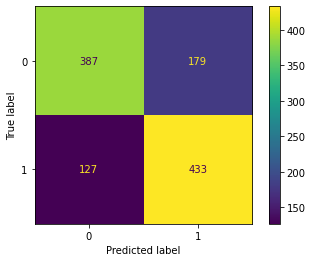

In [202]:
# Predictions on the test data
y_pred = my_logreg_opt.predict(X_baseline_test_scaled)

# Confusion Matrix
plot_confusion_matrix(my_logreg_opt, X_baseline_test_scaled, y_baseline_test, cmap='viridis')

print(classification_report(y_baseline_test, y_pred))

In [203]:
print(f"False Positive (Type I errors): {(round(179/566, 2)*100)}")

print(f"False Negative (Type II errors): {(round(127/560, 2)*100)}")

False Positive (Type I errors): 32.0
False Negative (Type II errors): 23.0


As we can see above:

- There are 433 True Positive and 387 true negative, which gives 73 % model accuracy
- False Positive, also known as Type I error, is up to ~ 32 % of predictions
- False Negative, also known as Type II error, is up to ~ 23 % of predictions
- Precision (positive predictions value is 71 %, which means, 71 % of all class 1 predictions were really class 1
- Recall (true positive rate) is 77 % , which means 77 % of "actual" class 1 are predicted correctly 

Now I will apply dimension reduction using PCA and check how the distribution would perform with less features.

In [204]:
# Instantiate & fit PCA model to the breast cancer data
# Default n_components will generate the same number of PCs as you have features 
my_PCA_baseline = PCA()
my_PCA_baseline.fit(X_baseline_train)

# transform data 
X_baseline_train_PCA = my_PCA_baseline.transform(X_baseline_train_scaled)
X_baseline_validation_PCA = my_PCA_baseline.transform(X_baseline_validation_scaled)
X_baseline_test_PCA = my_PCA_baseline.transform(X_baseline_test_scaled)

In [205]:
X_baseline_train.shape

(3603, 3318)

In [206]:
X_baseline_train_PCA.shape

(3603, 3318)

In [207]:
X_baseline_validation.shape

(901, 3318)

In [208]:
X_baseline_validation_PCA.shape

(901, 3318)

In [209]:
my_PCA_baseline.explained_variance_ratio_

array([9.99260328e-01, 4.73269447e-04, 5.04064969e-05, ...,
       3.50472760e-39, 2.42489238e-39, 2.38817723e-39])

By observing the results from the PCA explained variance ratio it is possible to interpret as the following:

* 99 % of the variation in the data is seen in the direction of the first PC
* 47 % of the variation in the data is seen in the direction of the second PC


Now I will plot to find out the best number of PCA.

<function matplotlib.pyplot.show(close=None, block=None)>

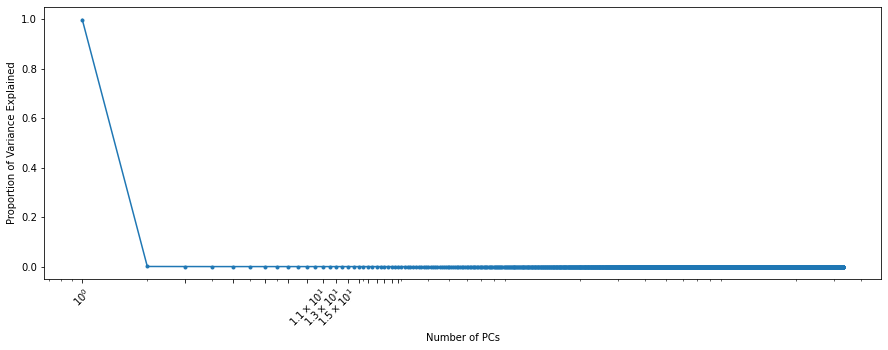

In [210]:
plt.figure(figsize=(15,5))
plt.plot(range(1,len(my_PCA_baseline.explained_variance_ratio_)+1), my_PCA_baseline.explained_variance_ratio_,marker='.')

plt.xscale('log')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,31,2))
plt.xticks(rotation=45)
plt.show

In [211]:
# Pull out the explained variance ratio
expl_var = my_PCA_baseline.explained_variance_ratio_

# Calculate the cumulative sum of this array using the 
cumulative_sum = np.cumsum(expl_var)

cumulative_sum

array([0.99926033, 0.9997336 , 0.999784  , ..., 1.        , 1.        ,
       1.        ])

We know that PC1 and PC2 explained 99% and 47% of the variance respectively. In our new cumulative sum array, we can see that the second value is 0.9997 (9.99260328e-01 + 4.73269447e-04). 

Therefore, we just need to pick the number of PCs that gives us a level of explained variance that meets our threshold.

<function matplotlib.pyplot.show(close=None, block=None)>

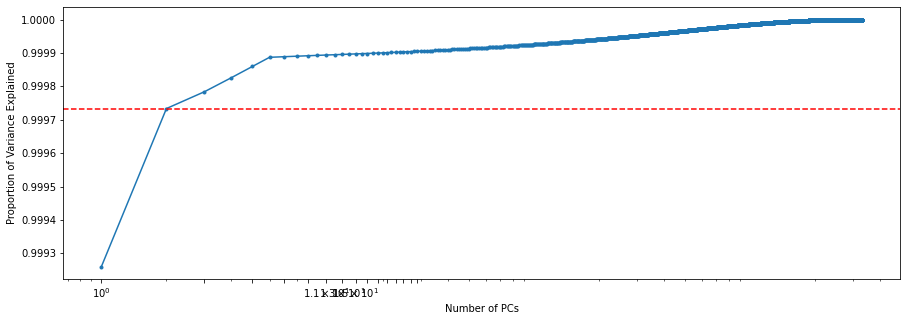

In [212]:
plt.figure(figsize=(15,5))
plt.plot(range(1,len(cumulative_sum)+1), cumulative_sum,marker='.')
plt.axhline(0.9997336, c='r', linestyle='--')
plt.xscale('log')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,31,2))
plt.show

It looks like the n_componets optimal is equal 2 where it presents around 99.9% explained variance.

In [213]:
#Fitting new PCA object
pca_target = PCA(n_components=0.9997336)

pca_target.fit(X_baseline_train_scaled)

# tranforming each subset in the same way
X_baseline_train_PCA = pca_target.transform(X_baseline_train_scaled)
X_baseline_validation_PCA = pca_target.transform(X_baseline_validation_scaled)
X_baseline_test_PCA = pca_target.transform(X_baseline_test_scaled)

In [214]:
pca_target.n_components_

3088

In [215]:
print(X_baseline_train_PCA.shape, X_baseline_validation_PCA.shape, X_baseline_test_PCA.shape)

(3603, 3088) (901, 3088) (1126, 3088)


As we could see, train, test and validatian have the same number of features.

In [216]:
# values of C to interate over
C_values = (.00001,.0001,.001,.01,.1,1,10,100,1000)

# create an empty list to store accuracy scores
train_acc_PCA = []
val_acc_PCA = []

# loop model interactions across all C-values

for C in C_values:
    logit_C_PCA = LogisticRegression(random_state=42, max_iter=1000, C=C).fit(X_baseline_train_PCA, y_baseline_train)
    
    train_acc_PCA.append(logit_C_PCA.score(X_baseline_train_PCA, y_baseline_train))
    val_acc_PCA.append(logit_C_PCA.score(X_baseline_validation_PCA, y_baseline_validation))
    print(f"C {C} completed")

C 1e-05 completed
C 0.0001 completed
C 0.001 completed
C 0.01 completed
C 0.1 completed
C 1 completed
C 10 completed
C 100 completed
C 1000 completed


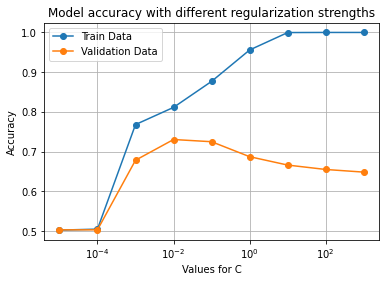

In [217]:
# Visualization part - accuracy scores across C-values

plt.figure()
plt.plot(C_values, train_acc_PCA, marker='o',label='Train Data')
plt.plot(C_values, val_acc_PCA, marker='o',label='Validation Data')
plt.xscale("log")

plt.xlabel('Values for C')
plt.ylabel('Accuracy')

plt.legend()
plt.title('Model accuracy with different regularization strengths')
plt.grid()
plt.show();

As we can see, according to the graphic, `C = 0.01` still being the best c value. But I will use both `C`=0.1 and `C`=0.01.

In [218]:
# Instantiate the model
my_logreg_PCA = LogisticRegression(C=0.1,random_state=42,max_iter=1000)

my_logreg_PCA.fit(X_baseline_train_PCA, y_baseline_train)

#score model against data subsets
my_logreg_train_PCA_acc_01 = my_logreg_PCA.score(X_baseline_train_PCA, y_baseline_train)

my_logreg_val_PCA_acc_01 = my_logreg_PCA.score(X_baseline_validation_PCA, y_baseline_validation)

my_logreg_test_PCA_acc_01 = my_logreg_PCA.score(X_baseline_test_PCA, y_baseline_test)

print(f"Train accuracy: {(round(my_logreg_train_PCA_acc_01,4)*100)}")
print(f"Validation accuracy: {(round(my_logreg_val_PCA_acc_01,4)*100)}")
print(f"Test accuracy: {(round(my_logreg_test_PCA_acc_01,4)*100)}")

Train accuracy: 87.68
Validation accuracy: 72.48
Test accuracy: 72.82


In [219]:
# Instantiate the model
my_logreg_PCA = LogisticRegression(C=0.01,random_state=42,max_iter=1000)

my_logreg_PCA.fit(X_baseline_train_PCA, y_baseline_train)

#score model against data subsets
my_logreg_train_PCA_acc = my_logreg_PCA.score(X_baseline_train_PCA, y_baseline_train)

my_logreg_val_PCA_acc = my_logreg_PCA.score(X_baseline_validation_PCA, y_baseline_validation)

my_logreg_test_PCA_acc = my_logreg_PCA.score(X_baseline_test_PCA, y_baseline_test)

print(f"Train accuracy: {(round(my_logreg_train_PCA_acc,4)*100)}")
print(f"Validation accuracy: {(round(my_logreg_val_PCA_acc,4)*100)}")
print(f"Test accuracy: {(round(my_logreg_test_PCA_acc,4)*100)}")

Train accuracy: 81.13
Validation accuracy: 73.03
Test accuracy: 72.28999999999999


Using `C`=0.01 the delta between Train and Test was smaller, so I will consider it as the best `C`.

* In conclusion:*


Before applying PCA, the accuracy results were as following:

Train: 87.7%          Validation: 72.48%          Test: 72.82%

After using PCA, with the reduced dimension, the new accuracy result were:

Train: 81.13%          Validation: 73.03%          Test: 72.29%


Even if the delta between Train and Test is still big, after applying the PCA we could not notice an improvement in our model. The Train accuracy had decreased almost 6.6%, but the Test accuracy slightly decreased, but the delta between Train and Test still big. 

Now I will try another model.

### K-Nearest Neighbor Classifier

Now I will check how the model will perform with KNN

In [220]:
knn = KNeighborsClassifier()

# Fit on the tranformed data
knn.fit(X_baseline_train_scaled, y_baseline_train)


print(f"Train accuracy: {(knn.score(X_baseline_train_scaled, y_baseline_train))}")
print(f"Validation accuracy: {(knn.score(X_baseline_validation_scaled, y_baseline_validation))}")
print(f"Test accuracy: {(knn.score(X_baseline_test_scaled, y_baseline_test))}")

Train accuracy: 0.6810990840965861
Validation accuracy: 0.5172031076581576
Test accuracy: 0.5168738898756661


Fitting a regular KNN without any optimization to the model, the `Test` accuracy was 51.68%.

Now, I will check how the model performs after applying hyperparameter optimization.

In [221]:
# values of k
K_values = np.arange(1,102,2)

# create an empty list to store accuracy scores
train_acc_Knn = []
val_acc_Knn = []


for k in K_values:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    Knn = knn.fit(X_baseline_train_scaled, y_baseline_train)
   
    train_acc_Knn.append(Knn.score(X_baseline_train_scaled, y_baseline_train))
    val_acc_Knn.append(Knn.score(X_baseline_validation_scaled, y_baseline_validation))
    
    print(f" {k} completed")

 1 completed
 3 completed
 5 completed
 7 completed
 9 completed
 11 completed
 13 completed
 15 completed
 17 completed
 19 completed
 21 completed
 23 completed
 25 completed
 27 completed
 29 completed
 31 completed
 33 completed
 35 completed
 37 completed
 39 completed
 41 completed
 43 completed
 45 completed
 47 completed
 49 completed
 51 completed
 53 completed
 55 completed
 57 completed
 59 completed
 61 completed
 63 completed
 65 completed
 67 completed
 69 completed
 71 completed
 73 completed
 75 completed
 77 completed
 79 completed
 81 completed
 83 completed
 85 completed
 87 completed
 89 completed
 91 completed
 93 completed
 95 completed
 97 completed
 99 completed
 101 completed


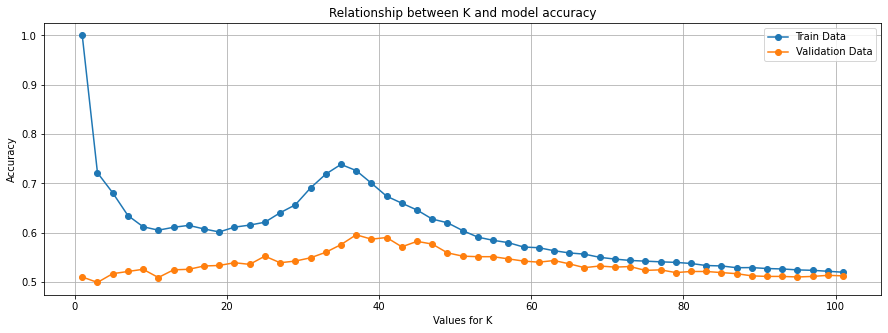

In [222]:
# Visualization part - accuracy scores across C-values

plt.figure(figsize=(15, 5))
plt.plot(K_values, train_acc_Knn, marker='o',label='Train Data')
plt.plot(K_values, val_acc_Knn, marker='o',label='Validation Data')


plt.xlabel('Values for K')
plt.ylabel('Accuracy')

plt.legend()
plt.title('Relationship between K and model accuracy')
plt.grid()
plt.show();

With the visual above, we can notice an elbow around k=9. But after that point, `train` and `test` are still not plateauing. So, by analysing the lines, I would choose k=45 which looks where after that point, validation and train start to plateau.

In [223]:
knn_optimum = KNeighborsClassifier(n_neighbors=45)

knn_optimum.fit(X_baseline_train_scaled, y_baseline_train)

knn_optimum_train_acc = knn_optimum.score(X_baseline_train_scaled, y_baseline_train)
knn_optimum_validation_acc = knn_optimum.score(X_baseline_validation_scaled, y_baseline_validation)
knn_optimum_test_acc = knn_optimum.score(X_baseline_test_scaled, y_baseline_test)

print(f"Optimized KNN model")
print(f"Train accuracy: {(round(knn_optimum_train_acc,4)*100)}")
print(f"Validation accuracy: {(round(knn_optimum_validation_acc,4)*100)}")
print(f"Test accuracy: {(round(knn_optimum_test_acc,4)*100)}")

Optimized KNN model
Train accuracy: 64.61
Validation accuracy: 58.269999999999996
Test accuracy: 58.60999999999999


              precision    recall  f1-score   support

           0       0.74      0.27      0.40       566
           1       0.55      0.90      0.68       560

    accuracy                           0.59      1126
   macro avg       0.64      0.59      0.54      1126
weighted avg       0.65      0.59      0.54      1126



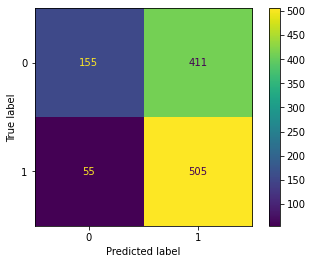

In [224]:
# Predictions on the test data
y_pred = knn_optimum.predict(X_baseline_test_scaled)

# Confusion Matrix
plot_confusion_matrix(knn_optimum, X_baseline_test_scaled, y_baseline_test, cmap='viridis')

print(classification_report(y_baseline_test, y_pred))

In [225]:
print(f"False Positive (Type I errors): {(round(411/566, 2)*100)}")

print(f"False Negative (Type II errors): {(round(55/560, 2)*100)}")

False Positive (Type I errors): 73.0
False Negative (Type II errors): 10.0


As we can see above:

- There are 505 True Positive and 155 true negative, which gives 59 % model accuracy
- False Positive, also known as Type I error, is up to ~ 73 % of predictions
- False Negative, also known as Type II error, is up to ~ 10 % of predictions
- Precision (positive predictions value is 55 %, which means, 55 % of all class 1 predictions were really class 1
- Recall (true positive rate) is 90 % , which means 90 % of "actual" class 1 are predicted correctly 

### Decision Tree Classifier

In [226]:
# Instatiating the model

dct = DecisionTreeClassifier()

# Fiting and scoring
dct.fit(X_baseline_train_scaled, y_baseline_train)

print(f"Train accuracy: {(dct.score(X_baseline_train_scaled, y_baseline_train))}")
print(f"Validation accuracy: {(dct.score(X_baseline_validation_scaled, y_baseline_validation))}")
print(f"Test accuracy: {(dct.score(X_baseline_test_scaled, y_baseline_test))}")

Train accuracy: 1.0
Validation accuracy: 0.7247502774694784
Test accuracy: 0.7477797513321492


When using the Decision Tree Classifier, if we do not indicate the depth of the tree, it tends to overfit. As we can observe above, the `Train` accuracy is equal 1 and `Test` accuracy equal 74.77%, which means the model is overfitting.

Now I will investigate the best depth.

In [227]:
# levels of depth
max_depths = [2,3,4,5,6,7,8,9,10,11,12]

# emptuy list
train_acc_dt = []
val_acc_dt = []

# interate over parameters values
for max_depth in max_depths:
    dtc_md = DecisionTreeClassifier(max_depth=max_depth)
    dtc_md.fit(X_baseline_train_scaled, y_baseline_train)
    
    train_acc_dt.append(dtc_md.score(X_baseline_train_scaled, y_baseline_train))
    val_acc_dt.append(dtc_md.score(X_baseline_validation_scaled, y_baseline_validation))

    print(f"Completed max_depth: {(max_depth)}")

Completed max_depth: 2
Completed max_depth: 3
Completed max_depth: 4
Completed max_depth: 5
Completed max_depth: 6
Completed max_depth: 7
Completed max_depth: 8
Completed max_depth: 9
Completed max_depth: 10
Completed max_depth: 11
Completed max_depth: 12


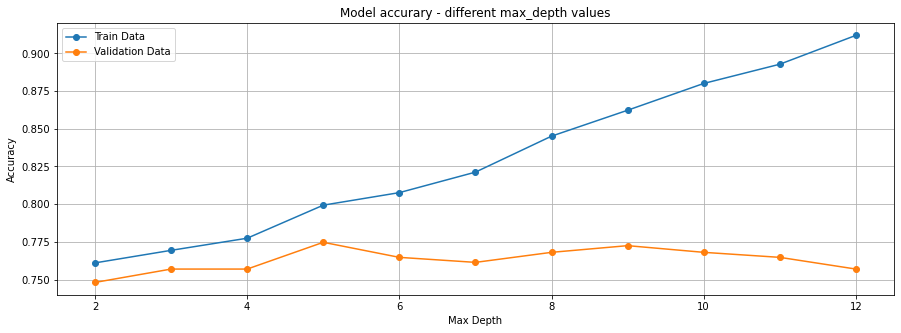

In [228]:
# Visualization part - accuracy scores across Decision Tree

plt.figure(figsize=(15, 5))
plt.plot(max_depths, train_acc_dt, marker='o',label='Train Data')
plt.plot(max_depths, val_acc_dt, marker='o',label='Validation Data')


plt.xlabel('Max Depth')
plt.ylabel('Accuracy')

plt.legend()
plt.title('Model accurary - different max_depth values')
plt.grid()
plt.show();

By looking at the visualisation above, it is possible to conclude that the best max_depth to be used is 5.

In [229]:
# Instatiating the model

dct_opt = DecisionTreeClassifier(max_depth=5)

# Fiting and scoring
dct_opt.fit(X_baseline_train_scaled, y_baseline_train)

dct_opt_train_acc = dct_opt.score(X_baseline_train_scaled, y_baseline_train)
dct_opt_validation_acc = dct_opt.score(X_baseline_validation_scaled, y_baseline_validation)
dct_opt_test_acc = dct_opt.score(X_baseline_test_scaled, y_baseline_test)


print(f"Train accuracy: {(round(dct_opt_train_acc,4)*100)}")
print(f"Validation accuracy: {(round(dct_opt_validation_acc,4)*100)}")
print(f"Test accuracy: {(round(dct_opt_test_acc,4)*100)}")

Train accuracy: 79.93
Validation accuracy: 77.47
Test accuracy: 79.57


The results from the Decision Tree defining the depth equal to 5 delivered a good improvement related to the `Test` accuracy.

              precision    recall  f1-score   support

           0       0.89      0.67      0.77       566
           1       0.74      0.92      0.82       560

    accuracy                           0.80      1126
   macro avg       0.81      0.80      0.79      1126
weighted avg       0.81      0.80      0.79      1126



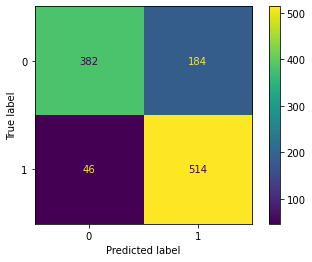

In [230]:
# Predictions on the test data
y_pred = dct_opt.predict(X_baseline_test_scaled)

# Confusion Matrix
plot_confusion_matrix(dct_opt, X_baseline_test_scaled, y_baseline_test, cmap='viridis')

print(classification_report(y_baseline_test, y_pred))

In [231]:
print(f"False Positive (Type I errors): {(round(184/566, 2)*100)}")

print(f"False Negative (Type II errors): {(round(46/560, 2)*100)}")

False Positive (Type I errors): 33.0
False Negative (Type II errors): 8.0


As we can see above:

- There are 514 True Positive and 382 true negative, which gives 80 % model accuracy
- False Positive, also known as Type I error, is up to ~ 33 % of predictions
- False Negative, also known as Type II error, is up to ~ 8 % of predictions
- Precision (positive predictions value is 74 %, which means, 74 % of all class 1 predictions were really class 1
- Recall (true positive rate) is 92 % , which means 92 % of "actual" class 1 are predicted correctly 

### Models Summary

In [232]:
print(f"Optimized logistic regression model")
print(f"Train accuracy: {(round(my_logreg_opt_train_acc,4)*100)}")
print(f"Validation accuracy: {(round(my_logreg_opt_validation_acc,4)*100)}")
print(f"Test accuracy: {(round(my_logreg_opt_test_acc,4)*100)}")
print(f"-----------------------------------------------------------")

print(f"Optimized Logistic Regression - PCA model")
print(f"Train accuracy: {(round(my_logreg_train_PCA_acc,4)*100)}")
print(f"Validation accuracy: {(round(my_logreg_val_PCA_acc,4)*100)}")
print(f"Test accuracy: {(round(my_logreg_test_PCA_acc,4)*100)}")
print(f"-----------------------------------------------------------")

print(f"Optimized KNN model")
print(f"Train accuracy: {(round(knn_optimum_train_acc,4)*100)}")
print(f"Validation accuracy: {(round(knn_optimum_validation_acc,4)*100)}")
print(f"Test accuracy: {(round(knn_optimum_test_acc,4)*100)}")
print(f"-----------------------------------------------------------")

print(f"Optimized Decision Tree")
print(f"Train accuracy: {(round(dct_opt_train_acc,4)*100)}")
print(f"Validation accuracy: {(round(dct_opt_validation_acc,4)*100)}")
print(f"Test accuracy: {(round(dct_opt_test_acc,4)*100)}")

Optimized logistic regression model
Train accuracy: 87.7
Validation accuracy: 72.48
Test accuracy: 72.82
-----------------------------------------------------------
Optimized Logistic Regression - PCA model
Train accuracy: 81.13
Validation accuracy: 73.03
Test accuracy: 72.28999999999999
-----------------------------------------------------------
Optimized KNN model
Train accuracy: 64.61
Validation accuracy: 58.269999999999996
Test accuracy: 58.60999999999999
-----------------------------------------------------------
Optimized Decision Tree
Train accuracy: 79.93
Validation accuracy: 77.47
Test accuracy: 79.57


After performing all the tree models (Logistic Regression, KNN and DT) without and with hyperparameters optimization, it was possible to conclude that the best performance achieved was by using Decision Tree. The f1 score for this model was ~80% while for LR and KNN was ~73% and ~59% respectively.

Therefore, next, I will use the `feature importance` on the Decision Tree best model to see the words with highest impact in the model.

### Decision Tree - Feature Importance

In [233]:
df_importance = pd.DataFrame({'Feature_names':X_baseline.columns, 'Importances':dct_opt.feature_importances_})

In [234]:
df_importance

,Feature_names,Importances
0,duration,0.041758
1,recorded_month,0.003248
2,published_month,0.000000
3,published_year,0.060148
4,count_related_videos,0.000000
...,...,...
3313,zimmerman,0.000000
3314,zone,0.000000
3315,–,0.000000
3316,—,0.000000


In [235]:
df_importance_sort = df_importance.sort_values(by='Importances', ascending=False)
df_importance_sort = df_importance_sort.head(16)
df_importance_sort

,Feature_names,Importances
7,popularity_ratio,0.500677
5,count_subtitle_languages,0.362131
3,published_year,0.060148
0,duration,0.041758
2729,smart,0.005001
1269,funni,0.004710
396,boost,0.004333
222,appli,0.003667
287,autism,0.003273
1,recorded_month,0.003248


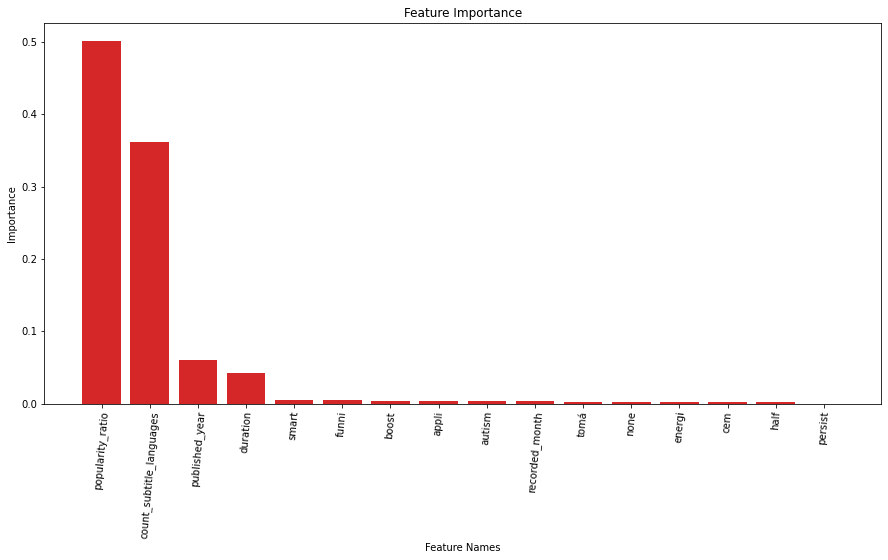

In [236]:
plt.figure(figsize=(15, 7))
plt.bar(df_importance_sort['Feature_names'], df_importance_sort['Importances'],color='tab:red')
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.xlabel("Feature Names")
plt.xticks(rotation=85)
plt.show()

As we can see, not all the words are completed. So, I will use a little creativity and see what I can build.

### Conclusion

After performing the vectorization using Bag of Words, I was able to use the one-hot-encoding columns and concatenate all the information in one unique data frame. During this process, I only used the standard model of Logistic Regression, K-Nearest Neighbor and Decision Tree in order to compare the three models.

The next step, before any modeling, I needed to split the data into Train, Validation and Test. So, I decided to use 20% of the total for the Test set. And then I split again, using 20% of the remainder for the validation.

The first model was Logistic Regression and since the beginning, it did not show a good performance. I began by checking the best C value. So, after defining the best one, I ran the model again and the delta between Train and Test were still very high. Therefore, I applied 5-fold cross validation and used a pipeline to check for multiple hyperparameters. In conclusion, after applying the best hyperparameters, the F1 score was 73% while the gap between Train and Test was almost 10%, which shows that the model was overfitting.

My second model was KNN and it also did not show good results before applying any hyperparameter optimization. So, I checked for the best k value and found out that the best would be k=45. The delta between Train and Test was smaller than using Logistic Regression, but the accuracy of this model was very bad, F1 score was equal 59%. So, I tried the next model.

The Decision Tree presented a good accuracy score for the test set without any hyperparameter optimization, however, the train set overfitted and its accuracy was 100%. So, I verified the best max_depth and found out that the best one was equal to five. 

When comparing all the models, Decision Tree, between all three, achieved the best performance with F1 equal to 80%. In addition, the delta between train and test was very small. Therefore, I used this model to extract the words with the most impact in the results. 
The words are the following:
smart | funni(est) | boost | appli(cation) | autism | toma(to) | none | energi(es) | cem(ent) | half

Not all the words are in proper English or complete. So, I will use a little creativity to construct a description with these words.

**“Let’s talk about autism. I would guess that half of the guests in here do not know a great deal about this subject, it does not matter if you consider yourself smart and the funniest, tomato /tomato. I want to present ideas that would boost your knowledge. (...)**

**(…)So, those are some of the applications you should consider. Your brain is like a truck full of cement, if you stop applying energy to move it, it will  get stuck. Therefore, none of your previous efforts will make a difference(...)”**

Therefore, after completing this notebook with the modeling, I used Recurrent Neural Networks word embeddings to identify words that could be predicted by using the description information. In the next notebook called ` Notebook_3_RNN_TED_Talk` you will find all the work done and by the end I presented a description using the new set of words found throughout RNN. In this notebook, I will also compare the two sets of words.

Moreover, I would like to mention that for the `Notebook_3_RNN_TED_Talk` I used a special conda environment which you can find in the README.text.

Please, use the same csv file used in this notebook for the next one.